In [1]:
from typing import Callable, List, Tuple, Optional
from math import sqrt, inf
from enum import Enum
from copy import deepcopy


# Derivação numerica

In [2]:
DELTA_DERIVACAO_PADRAO = 10**-4


def derivada_direita(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x + delta) - f(x)) / delta


def derivada_esquerda(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x - delta) - f(x)) / delta


def derivada_central(f: Callable[[float], float], delta=DELTA_DERIVACAO_PADRAO):
    return lambda x: (f(x + delta) - f(x - delta)) / (2 * delta)


# Métodos iterativos

## Calculo do erro

In [3]:
def erro_absoluto(referencia: float, estimativa: float) -> float:
    return abs(referencia - estimativa)


def erro_relativo(referencia: float, estimativa: float) -> float:
    return abs((referencia - estimativa) / estimativa)


## Condições de parada

In [4]:
MAX_ITER_PADRAO = 100


def limite_iteracao(i: int):
    return lambda est: est.i >= i


def criterio_erro_absoluto(referencia: float, erro_max: float):
    return lambda est: erro_absoluto(referencia, est.x) < erro_max


def criterio_ab(erro_max: float):
    return lambda est: est.b - est.a < 2 * erro_max


def criterio_x(erro_max: float):
    return lambda est: est.f(est.x - erro_max) * est.f(est.x + erro_max) < 0


def criterio_delta_x(delta: float):
    return lambda est: est.prior_x is not None and abs(est.x - est.prior_x) < delta


def criterio_y(dist_zero: float):
    return lambda est: abs(est.y) < dist_zero


## Método da bisseçao

In [5]:
class EstatisticaAB:
    def __init__(
        self, f: Callable[[float], float], a: float, b: float, x: float, y: float
    ) -> None:
        self.f = f
        self.i: int = 1
        self.a = a
        self.b = b
        self.prior_x = None
        self.x = x
        self.y = y

    def atualizar(self, a: float, b: float, x: float, y: float):
        self.i += 1
        self.a = a
        self.b = b
        self.prior_x = x
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, a: {self.a}, b: {self.b}, x: {self.x}, y: {self.y}"


In [6]:
def bissecao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstatisticaAB], bool]],
    observador: Callable[[EstatisticaAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    if a > b:
        a, b = b, a
    i = 1
    x = (a + b) / 2
    y = f(x)
    est = EstatisticaAB(f, a, b, x, y)
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        i += 1
        if f(a) * y < 0:
            b = x
        else:
            a = x
        x = (a + b) / 2
        y = f(x)
        est_erro = (b - a) / 2
        est.atualizar(a, b, x, y)
        observador(est)
    return est


## Método da falsa posição

In [7]:
def falsa_posicao(
    f: Callable[[float], float],
    a: float,
    b: float,
    criterios: list[Callable[[EstatisticaAB], bool]],
    observador: Callable[[EstatisticaAB], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    if a > b:
        a, b = b, a
    i = 1
    x = (a * f(b) - b * f(a)) / (f(b) - f(a))
    y = f(x)
    est = EstatisticaAB(f, a, b, x, y)
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        i += 1
        if f(a) * y < 0:
            b = x
        else:
            a = x
        x = (a * f(b) - b * f(a)) / (f(b) - f(a))
        y = f(x)
        est_erro = (b - a) / 2
        est.atualizar(a, b, x, y)
        observador(est)
    return est


## Método do ponto fixo

In [8]:
class EstatisticaX:
    def __init__(
        self,
        f: Callable[[float], float],
        fi: Callable[[float], float],
        x: float,
        y: float,
    ) -> None:
        self.i: int = 1
        self.f = f
        self.fi = fi
        self.prior_x = None
        self.x = x
        self.y = y

    def atualizar(self, x: float, y: float):
        self.i += 1
        self.prior_x = x
        self.x = x
        self.y = y

    def __str__(self) -> str:
        return f"iteracao: {self.i}, x: {self.x}, y:{self.y}"


In [9]:
from pickle import NONE


def ponto_fixo(
    f: Callable[[float], float],
    fi: Callable[[float], float],
    x: float,
    criterios: list[Callable[[EstatisticaX], bool]],
    observador: Callable[[EstatisticaX], None] = lambda _: None,
    max_iter=MAX_ITER_PADRAO,
):
    i = 1
    y = f(x)
    est = EstatisticaX(f, fi, x, y)
    observador(est)
    while not all(map(lambda c: c(est), criterios)) and est.i < max_iter:
        i += 1
        x = fi(x)
        y = f(x)
        est.atualizar(x, y)
        observador(est)
    return est


## Método de Newtown-Raphson

In [10]:
def newton_raphson(
    f: Callable[[float], float],
    x: float,
    criterios: List[Callable[[EstatisticaX], bool]],
    observador: Callable[[EstatisticaX], None] = lambda x: None,
    max_iter=MAX_ITER_PADRAO,
):
    d = derivada_central(f)
    fi = lambda x: x - f(x) / d(x)
    return ponto_fixo(f, fi, x, criterios, observador, max_iter)


# Sistemas lineares

## Método de Gauss

In [11]:
def multiplicar_somar(
    fator: float,
    ori: int,
    dest: int,
    b: List[List[float]],
    y: Optional[List[float]] = None,
):
    colunas = len(b[0])
    for c in range(colunas):
        b[dest][c] += fator * b[ori][c]
    if y is not None:
        y[dest] += fator * y[ori]
    pass


def busca_pivo(linha: int, coluna: int, b: List[List[float]]):
    maior = -inf
    posicao = -1
    for l in range(linha, len(b)):
        valor = abs(b[l][coluna])
        if valor > maior:
            maior = valor
            posicao = l
    return posicao


def elimininacao_gauss(
    linha: int, coluna: int, b: List[List[float]], y: Optional[List[float]] = None
):
    for l in range(linha + 1, len(b)):
        fator = b[l][coluna] / b[linha][coluna]
        multiplicar_somar(-fator, linha, l, b, y)
    pass


def gauss(
    b: List[List[float]], y: Optional[List[float]] = None
) -> Tuple[List[List[float]], Optional[List[float]]]:
    b, y = deepcopy(b), deepcopy(y)
    l, c = 0, 0
    m, n = len(b), len(b[0])
    while l < m and c < n:
        linha_pivo = busca_pivo(l, c, b)
        if linha_pivo != -1:
            b[l], b[linha_pivo] = b[linha_pivo], b[l]
            if y is not None:
                y[l], y[linha_pivo] = y[linha_pivo], y[l]
            elimininacao_gauss(l, c, b, y)
            l += 1
            c += 1
        else:
            c += 1
    return b, y


## Tipo Solução

In [12]:
class TipoSolucao(Enum):
    NENHUMA = 0
    UNICA = 1
    MULTIPLAS = 2


def tipo_solucao(b, y) -> TipoSolucao:
    for i in range(len(b)):
        if b[i][i] == 0.0:
            if y[i] == 0.0:
                return TipoSolucao.MULTIPLAS
            else:
                return TipoSolucao.NENHUMA
    return TipoSolucao.UNICA


## Substituição Retroativa

In [13]:
def substituicao_retroativa(b: List[List[float]], y: List[float]) -> List[float]:
    if tipo_solucao(b, y) != TipoSolucao.UNICA:
        raise ValueError("a matriz dada não adimite solução unica")
    n = len(y)
    x = [0.0] * n
    for i in reversed(range(n)):
        s = sum((b[i][j] * x[j] for j in range(i + 1, n)))
        x[i] = (y[i] - s) / b[i][i]
    return x


## Solucionar sistema

In [14]:
def solucionar_linear(b: List[List[float]], y: List[float]):
    b, y = gauss(b, y)  # type: ignore
    x = substituicao_retroativa(b, y)
    return x


# Método de Gauss-Seidel

In [15]:
def criterio_da_distancia_relativa(e):
    def criterio(x_ant, x):
        dr = max((abs(i - j) for i, j in zip(x_ant, x)))
        return dr < e

    return criterio


def progride(a, b, x_ant):
    n = len(a)
    x = [0] * n
    for i in range(n):
        s1 = sum((a[i][j] * x_ant[j]) for j in range(i))
        s2 = sum((a[i][j] * x_ant[j] for j in range(i + 1, n)))
        x[i] = (b[i] - s1 - s2) / a[i][i]
    return x


def gauss_seidel(b, y, x_inicial, criterio, max_iter=10000):
    i = 1
    x_ant = x_inicial
    x = progride(b, y, x_ant)
    i += 1
    while not criterio(x_ant, x) and i < max_iter:
        x_ant = x
        x = progride(b, y, x_ant)
        i += 1
    return x


# Amostras

In [16]:
def amostra_linear(x):
    return 5 * x + 2


def amostra_poli(x):
    return x**2 + x - 6


def amostra_poli_iter(x):
    return sqrt(6 - x)


# Playground 

In [17]:
# matplotlib e numpy usadas apenas para visualização
import matplotlib.pyplot as plt
import numpy as np


In [18]:
def q1_f(x: float) -> float:
    f = lambda y: x**2 + x * y - y**3 + 1
    res = newton_raphson(f, 1, [criterio_x(10**-8)])
    return res.x


def q1_df(x: float) -> float:
    f = lambda y: 2 * x + x * y + x - 3 * y**2
    res = newton_raphson(f, 1, [criterio_x(10**-4)])
    return res.x


In [19]:
x = np.linspace(-20.0, 20.0)


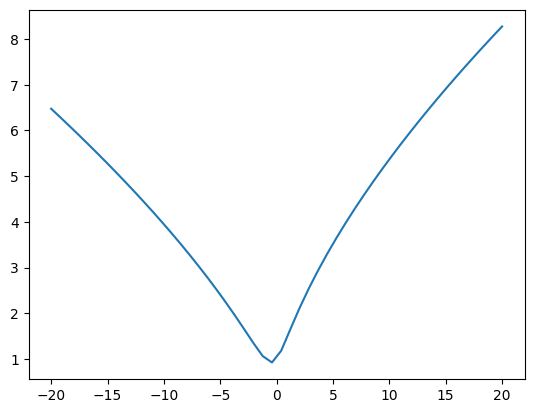

In [20]:
# Questão 1 a
y = np.vectorize(q1_f)(x)
_ = plt.plot(x, y)


minimo em (-0.7176230882589505, 0.9429121206314056)


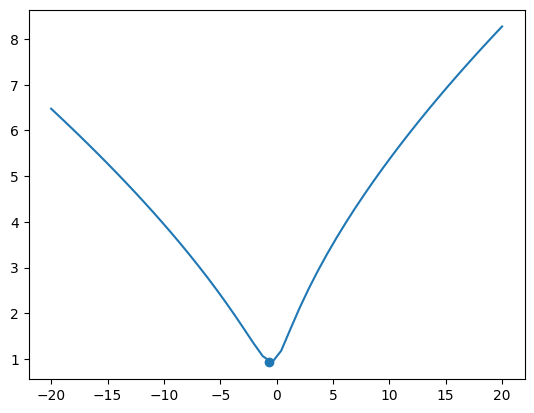

In [21]:
# Questão 1 b
minimo_x = newton_raphson(q1_df, 1, [criterio_x(10**-4)]).x
minimo_y = q1_f(minimo_x)
print(f"minimo em ({minimo_x}, {minimo_y})")
plt.plot(x, y)
_ = plt.scatter([minimo_x], [minimo_y])


In [22]:
# Questão 2 a
b = [[1.0, 4.0, 3.0], [2.0, 1.0, 3.0], [2.0, 3.0, 1.0]]
y = [1.0, 6.0, 8.0]

print("antes de gauss")
print("b =", b)
print("y =", y)

res_b, res_y = gauss(b, y)

print("depois de gauss")
print("b =", res_b)
print("y =", res_y)


antes de gauss
b = [[1.0, 4.0, 3.0], [2.0, 1.0, 3.0], [2.0, 3.0, 1.0]]
y = [1.0, 6.0, 8.0]
depois de gauss
b = [[2.0, 1.0, 3.0], [0.0, 3.5, 1.5], [0.0, 0.0, -2.857142857142857]]
y = [6.0, -2.0, 3.142857142857143]


In [23]:
# Questão 2 b
x = solucionar_linear(b, y)
print("x =", x)


x = [4.7, -0.10000000000000002, -1.0999999999999999]


In [ ]:
# Questão 3
b = [
    [9, -2, 1, 3, 1],
    [1, -1, 2, 6, 1],
    [2, -3, 7, 1, 0],
    [1, 6, -1, 4, 2],
    [1, -2, 2, 1, 8],
]

y = [0, 2, 1, 1, 2]

x_inicial = [1, 1, 1, 1, 1]

x = gauss_seidel(b, y, x_inicial, criterio_da_distancia_relativa(10**-4))

print(x)
